In [1]:
import numpy as np
import os 
import torch
import torchvision.transforms as transforms
import mlflow
import matplotlib.pyplot as plt
from src.emote2pitch import Emote2Pitch
from src.eval import inception_score, NDB
from PIL import Image
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if (torch.cuda.is_available() > 0) else "cpu")

## Generating data for eval

In [2]:
image_size = 256
emots = ['happy', 'angry', 'sad', 'surprise']
root = os.path.join('data','FER', 'test')
n_samples_per_class = 800


transform = transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5)),
                            ])

test_samples = []
for e in emots:
    emote_pth = os.path.join(root, e)
    sample_files_names = os.listdir(emote_pth)[:n_samples_per_class]
    for sample_image in sample_files_names:
        smpl = torch.zeros((1,1,image_size, image_size))
        x = Image.open(os.path.join(emote_pth, sample_image))
        smpl[0] = transform(x)

        test_samples.append((smpl, f'{e}-{sample_image}'))

## Available models

In [5]:
experiment_id = 0 
df = mlflow.search_runs([str(experiment_id)])
df[['tags.mlflow.runName', 'run_id', 'tags.spectrogram', 'tags.HZ', 'status']]

,tags.mlflow.runName,run_id,tags.spectrogram,tags.HZ,status
0,E2P-cGAN-constant-qv2-22050HZ-3split,6315bfd1a2d14e308bf0d388b7016075,constant-qv2,22050,FAILED
1,E2P-cGAN-mel-22050HZ-3split,a5c563aa801e4cdca49a50e9e13fbe55,mel,22050,FAILED
2,E2P-cGAN-chromagram-22050HZ-3split,234d8793933f4751b1d71b1ef9468fc5,chromagram,22050,FAILED
3,E2P-cGAN-constant-q-22050HZ-3split,79c2ca50c15e4a27a594880e631861c9,constant-q,22050,FINISHED
4,E2P-cGAN-mel-44100HZ-3split,a666c63288754e3bad47c83ff9db85e8,mel,44100,FINISHED
5,E2P-cGAN-chromagram-44100HZ-3split,0e9bfe6ae52b4280acc0719dc5ced899,chromagram,44100,FINISHED
6,E2P-cGAN-constant-q-44100HZ-3split,d7824e2af67f47cba2ab8a3cef65cab5,constant-q,44100,FINISHED
7,OLDRUN_E2P-cGAN-44100-3split,604e74d46fa64e4e88ed3a586bcc6259,None,44100,FINISHED
8,OLDRUN_E2P-cGAN-22050HZ-3split,b9a3e11dc0eb47a3a6a54216544d5c3f,None,None,FINISHED


## Generating spectrograms for finished models

In [6]:
runs = df[~(df['tags.spectrogram'].isnull())][['tags.mlflow.runName', 'run_id']].values

run_tqdm = tqdm(runs)
for run_name, run_id in run_tqdm:

    with mlflow.start_run(run_id=run_id):
        run_tqdm.set_description(f'Evaluating mdl: {run_name}')
        # Get model
        model_pth  = os.path.join('mlruns', '0', run_id, 'artifacts', '300', 'mdl.pth')
        e2p = Emote2Pitch()
        e2p.load_state_dict(torch.load(model_pth))
        e2p.eval()

        # Use Generator to create spectrograms
        generated = []
        ts_tqdm = tqdm(test_samples, desc=f'Generating spectrograms', leave=False)
        for ts in ts_tqdm:
            generated.append(e2p.G(ts[0]).detach().numpy()[0][0])

        # Transform data for inception 
        scale_samples = np.array(generated)*255
        transformer = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Lambda(lambda image: image.convert('RGB')),
            transforms.ToTensor()
        ]) 
        transformed_spectrograms = [transformer(smpl) for smpl in scale_samples]

        # getting inception results
        print('Calculating Inception Score')
        incep_mean, incep_std = inception_score(transformed_spectrograms, splits=4)
        #logging 
        mlflow.log_metrics({
            'inception_mean': incep_mean,
            'inception_std': incep_std
        })

        # NDB

        # Transforming Data 
        flat = scale_samples.reshape(scale_samples.shape[0], -1)
        dim = int(len(flat)*0.5)
        test_flat = flat[:dim]
        train_flat = flat[dim:]

        # Getting NDB
        print('Calculating Number of Distinct Bins')
        ndb = NDB(train_flat, number_of_bins=4, whitening=True)
        res = ndb.evaluate(test_flat, model_label='Test')

        # logging 
        mlflow.log_metric('NDB', res['NDB'])
        mlflow.log_metric('JS', res['JS'])


  0%|          | 0/7 [00:00<?, ?it/s]

Generating spectrograms:   0%|          | 0/3200 [00:00<?, ?it/s]

Calculating Inception Score
3200 / 3200
Computing KL-Div Mean...
4 / 4
Calculating Number of Distinct Bins
Performing K-Means clustering of 1600 samples in dimension 10922 / 65536 to 4 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1600 samples...
....


Generating spectrograms:   0%|          | 0/3200 [00:00<?, ?it/s]

Calculating Inception Score
3200 / 3200
Computing KL-Div Mean...
4 / 4
Calculating Number of Distinct Bins
Performing K-Means clustering of 1600 samples in dimension 10922 / 65536 to 4 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1600 samples...
....


Generating spectrograms:   0%|          | 0/3200 [00:00<?, ?it/s]

Calculating Inception Score
3200 / 3200
Computing KL-Div Mean...
4 / 4
Calculating Number of Distinct Bins
Performing K-Means clustering of 1600 samples in dimension 10922 / 65536 to 4 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1600 samples...
....


Generating spectrograms:   0%|          | 0/3200 [00:00<?, ?it/s]

Calculating Inception Score
3200 / 3200
Computing KL-Div Mean...
4 / 4
Calculating Number of Distinct Bins
Performing K-Means clustering of 1600 samples in dimension 10922 / 65536 to 4 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1600 samples...
....


Generating spectrograms:   0%|          | 0/3200 [00:00<?, ?it/s]

Calculating Inception Score
3200 / 3200
Computing KL-Div Mean...
4 / 4
Calculating Number of Distinct Bins
Performing K-Means clustering of 1600 samples in dimension 10922 / 65536 to 4 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1600 samples...
....


Generating spectrograms:   0%|          | 0/3200 [00:00<?, ?it/s]

Calculating Inception Score
3200 / 3200
Computing KL-Div Mean...
4 / 4
Calculating Number of Distinct Bins
Performing K-Means clustering of 1600 samples in dimension 10922 / 65536 to 4 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1600 samples...
....


Generating spectrograms:   0%|          | 0/3200 [00:00<?, ?it/s]

Calculating Inception Score
3200 / 3200
Computing KL-Div Mean...
4 / 4
Calculating Number of Distinct Bins
Performing K-Means clustering of 1600 samples in dimension 10922 / 65536 to 4 clusters ...
Can take a couple of minutes...
Done.
Calculating bin assignments for 1600 samples...
....


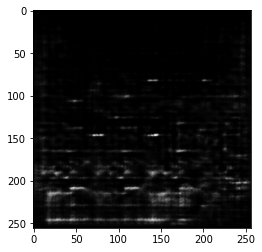

In [ ]:
_pth = os.path.join('mlruns', '0', 'd7824e2af67f47cba2ab8a3cef65cab5','artifacts', '1', 'angry-PrivateTest_10131363.jpg.npy')
x = np.load(_pth)
plt.imshow(x[0][0], cmap='binary')

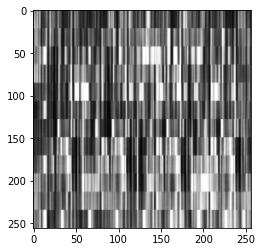

In [ ]:
_pth = os.path.join('mlruns', '0', '0e9bfe6ae52b4280acc0719dc5ced899','artifacts', '300', 'angry-PrivateTest_10131363.jpg.npy')
x = np.load(_pth)
plt.imshow(x[0][0], cmap='binary')